In [535]:
include("utils/GlobalUsings.jl")
include("utils/DataLoader.jl")
include("Lib/CustomDiffLib.jl")
include("utils/NetFunctions.jl")

include("utils/Ploter.jl")

plotTestAccuracty (generic function with 1 method)

In [569]:
X_train, y_train, X_test, y_test, classes  = getPrepearedData()
nothing

In [537]:
include("nets/netFlux.jl")
fluxNet, opt, loss, params = getDefaultFlux()
fluxLossHistory, fluxAccuracyHistory = train(fluxNet, params, X_train, y_train, 5, opt, loss)
fluxAccuracyVal = getFluxAccuracyVal(fluxAccuracyHistory)
fluxAccuracyVal, fluxAccuracyHistory


(0.5, [0.43333333333333335, 0.4666666666666667, 0.4666666666666667, 0.4666666666666667, 0.6666666666666666])

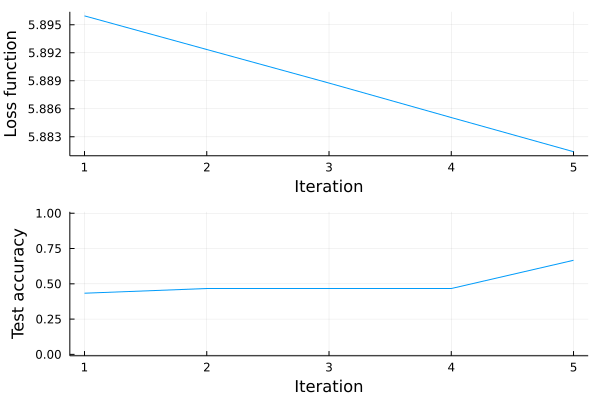

In [538]:
plotLossAccuracu(fluxLossHistory, fluxAccuracyHistory)

In [539]:
include("nets/NetAnia.jl")
aniaNet = getDefaultAniaNet()
aniaLossHistory, AniaAccHistory = trainAnia(aniaNet, X_train, y_train, 5, 0.01)
acc_history, AniaTestAccVal = accuracy(aniaNet, X_test, y_test)

([0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0  …  1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0], 76.66666666666667)

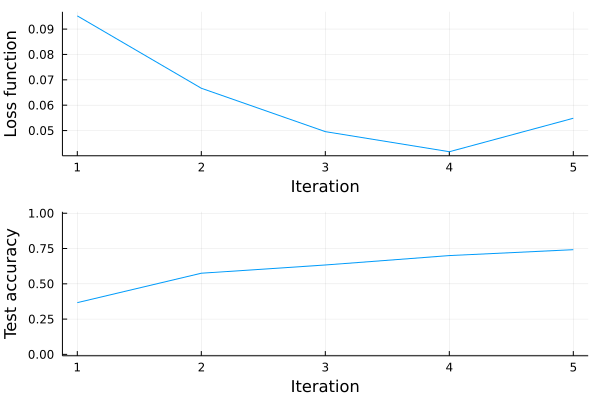

In [540]:
plotLossAccuracu(aniaLossHistory, AniaAccHistory)

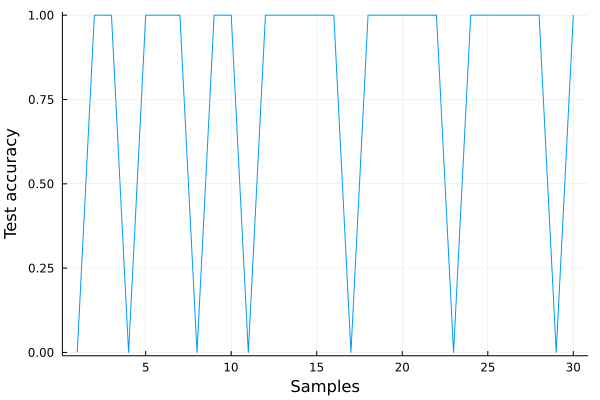

In [541]:
plotTestAccuracty(acc_history)

In [542]:
include("nets/netSebastian.jl")
sebastianNet = getSebastianDefaultNet()
Loss, acc = trainSebastian(sebastianNet, X_train, y_train, 5, 0.01)

([0.20191668667842821, 0.19780998884468481, 0.19450656964721447, 0.19176245044540763, 0.189402897800429], [0.4861527926641233, 0.49016946706478665, 0.49016946706478665, 0.49016946706478665, 0.49016946706478665])

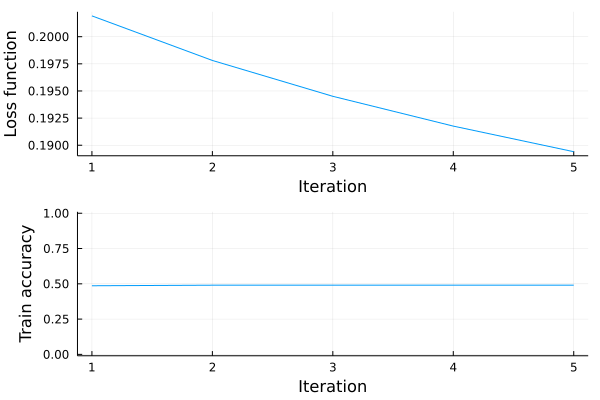

In [543]:
plotLossAccuracy(Loss, acc)

In [544]:
sebastianTestAccuracuy, sebastianTestAccVal=accuracySebastian(sebastianNet, X_test, y_test)
nothing

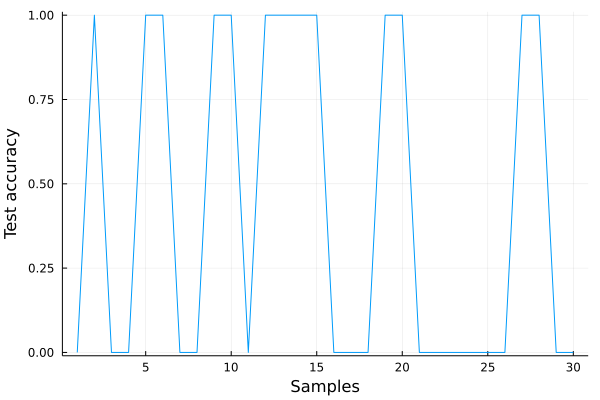

In [545]:
plotTestAccuracty(sebastianTestAccuracuy)

In [566]:
df_learning_results = DataFrame(Net= String[], TestAccuracy=Float64[], TrainAccuracy=Float64[],LossFunctionMinimum=Float64[])
push!(df_learning_results, ("Flux", 0.4, 0.3, 0.3))
push!(df_learning_results, ("Ania", AniaTestAccVal, 0.3, 0.3))
push!(df_learning_results, ("Sebastian", sebastianTestAccVal, 0.3, 0.3))


,Net,TestAccuracy,TrainAccuracy,LossFunctionMinimum
,String,Float64,Float64,Float64
1,Flux,0.4,0.3,0.3
2,Ania,76.6667,0.3,0.3
3,Sebastian,43.3333,0.3,0.3
